In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import random
import pickle

# Load dataset
file_path = 'selected_features_fast.csv'
df = pd.read_csv(file_path)
df = df.iloc[1:].reset_index(drop=True)  # Drop first row (feature names)

# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
y = LabelEncoder().fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chimp Optimization Algorithm (ChOA) for hyperparameter tuning
def choa_optimize(num_iterations=10, population_size=5):
    best_hyperparams = None
    best_accuracy = 0

    population = [
        {"learning_rate": random.uniform(0.0001, 0.01),
         "neurons": random.choice([64, 128, 256]),
         "dropout": random.uniform(0.2, 0.5),
         "batch_size": random.choice([32, 64, 128])} for _ in range(population_size)]

    for iteration in range(num_iterations):
        for i in range(population_size):
            params = population[i]

            model = Sequential([
                Dense(params["neurons"], activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(params["dropout"]),
                Dense(params["neurons"] // 2, activation='relu'),
                Dropout(params["dropout"] / 2),
                Dense(len(np.unique(y)), activation='softmax')
            ])

            model.compile(optimizer=Adam(learning_rate=params["learning_rate"]),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=10, batch_size=params["batch_size"],
                      validation_split=0.2, callbacks=[early_stopping], verbose=0)

            _, accuracy = model.evaluate(X_test, y_test, verbose=0)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparams = params

        for i in range(population_size):
            population[i]["learning_rate"] = np.clip(best_hyperparams["learning_rate"] + random.uniform(-0.001, 0.001), 0.0001, 0.01)
            population[i]["dropout"] = np.clip(best_hyperparams["dropout"] + random.uniform(-0.05, 0.05), 0.2, 0.5)

    return best_hyperparams

# Run ChOA optimization
best_params_choa = choa_optimize(num_iterations=10, population_size=5)
print("Best Hyperparameters Found using ChOA:", best_params_choa)

# Train model using best ChOA hyperparameters
choa_model = Sequential([
    Dense(best_params_choa["neurons"], activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(best_params_choa["dropout"]),
    Dense(best_params_choa["neurons"] // 2, activation='relu'),
    Dropout(best_params_choa["dropout"] / 2),
    Dense(len(np.unique(y)), activation='softmax')
])

choa_model.compile(optimizer=Adam(learning_rate=best_params_choa["learning_rate"]),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
choa_model.fit(X_train, y_train, epochs=50, batch_size=best_params_choa["batch_size"],
               validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the trained ChOA model
choa_model.save("leukemia_classifier_choa.h5")
print("Model saved as leukemia_classifier_choa.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters Found using ChOA: {'learning_rate': 0.001216105318568151, 'neurons': 128, 'dropout': 0.2276547390249169, 'batch_size': 128}
Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7875 - loss: 0.5447 - val_accuracy: 0.9605 - val_loss: 0.1187
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9539 - loss: 0.1369 - val_accuracy: 0.9701 - val_loss: 0.0824
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9691 - loss: 0.0892 - val_accuracy: 0.9785 - val_loss: 0.0637
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9773 - loss: 0.0634 - val_accuracy: 0.9804 - val_loss: 0.0530
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9800 - loss: 0.0568 - val_accuracy: 0.9835 - val_loss: 0.0517
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9848 - loss: 0.0444 - val_accuracy: 0.9850 - val_loss: 0.0413
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9860 - loss: 0.0387 - val_accurac

Model saved as leukemia_classifier_choa.h5


In [ ]:
from sklearn.preprocessing import StandardScaler
import pickle

# Load dataset
file_path = 'selected_features_fast.csv'
df = pd.read_csv(file_path)
df = df.iloc[1:].reset_index(drop=True)  # Drop first row (feature names)

# Separate features and labels
X = df.iloc[:, :-1].values

# Recreate and fit scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved successfully!")


Scaler saved successfully!


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle
import pandas as pd

# Load dataset
file_path = 'selected_features_fast.csv'
df = pd.read_csv(file_path)
df = df.iloc[1:].reset_index(drop=True)  # Drop first row (feature names)

# Extract labels
y = df.iloc[:, -1].values

# Recreate and fit label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Label encoder saved successfully!")


Label encoder saved successfully!


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0331
Test Accuracy: 98.81%
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9881
Precision: 0.9881
Recall: 0.9881
F1-score: 0.9881
AUC-ROC: 0.9998


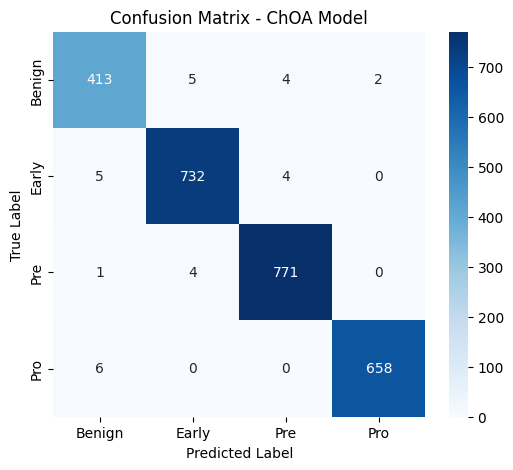

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = 'selected_features_fast.csv'
df = pd.read_csv(file_path)
df = df.iloc[1:].reset_index(drop=True)  # Drop first row (feature names)

# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Load scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
X = scaler.transform(X)

# Load label encoder
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
y = label_encoder.transform(y)

# Split into train and test sets
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load ChOA model
choa_model = load_model("leukemia_classifier_choa.h5")

# Evaluate on test data
loss, acc = choa_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Get predictions
y_pred_probs = choa_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Compute AUC-ROC (One-vs-Rest approach for multi-class)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))
auc_roc = roc_auc_score(y_test_one_hot, y_pred_probs, multi_class='ovr')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ChOA Model")
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Define k-fold cross-validation
k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Store results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

# Perform cross-validation
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create model using best ChOA hyperparameters
    model = Sequential([
        Dense(best_params_choa["neurons"], activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(best_params_choa["dropout"]),
        Dense(best_params_choa["neurons"] // 2, activation='relu'),
        Dropout(best_params_choa["dropout"] / 2),
        Dense(len(np.unique(y)), activation='softmax')  # Output layer
    ])

    model.compile(optimizer=Adam(learning_rate=best_params_choa["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=best_params_choa["batch_size"],
              validation_data=(X_val, y_val), verbose=0)

    # Predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics for this fold
    accuracy_scores.append(accuracy_score(y_val, y_pred_classes))
    precision_scores.append(precision_score(y_val, y_pred_classes, average="weighted"))
    recall_scores.append(recall_score(y_val, y_pred_classes, average="weighted"))
    f1_scores.append(f1_score(y_val, y_pred_classes, average="weighted"))
    auc_scores.append(roc_auc_score(y_val, y_pred, multi_class="ovr"))

# Print averaged results
print(f"Cross-Validation Results (k={k}):")
print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"AUC-ROC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Cross-Validation Results (k=5):
Accuracy: 0.9906 ± 0.0006
Precision: 0.9906 ± 0.0006
Recall: 0.9906 ± 0.0006
F1-score: 0.9906 ± 0.0006
AUC-ROC: 0.9997 ± 0.0001
